# **Final Project Task 5 - Census Modeling NN Regression**

Requirements

- Create a NN regression model on the Census dataset, with 'hours-per-week' target

- Model Selection and Setup:
    - Build a neural network model using a deep learning library like TensorFlow, Keras or PyTorch.
    - Choose a loss (or experiment with different losses) for the model and justify the choice.
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons.


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation
    - Establish a Baseline Model:
        - Train a simple NN model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable.
    - Feature Selection:
        - Neural Networks can learn feature importance automatically, so all relevant features should be included rather than manually selecting a subset.
        - Consider using embeddings for high-cardinality categorical features instead of one-hot encoding to improve efficiency.
    - Experimentation:
        - Focus on preprocessing techniques rather than manually selecting feature combinations. Ensure numerical features are normalized (e.g., MinMaxScaler, StandardScaler) and categorical features are properly encoded (e.g., one-hot encoding or embeddings for high-cardinality variables).
        - Experiment with different neural network architectures (e.g., number of layers, neurons per layer) and hyperparameters (e.g., activation functions, learning rates, dropout rates, and batch sizes).
        - Use techniques such as early stopping and learning rate scheduling to optimize model performance and prevent overfitting.
        - Identify the best model which have the best performance metrics on test set.
    - Hyperparameter Tuning:
        - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments.
        - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
        - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
        - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation
    - Evaluate models on the test dataset using regression metrics:
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice
    - Compare the results across different models. Save all experiment results into a table.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


**0. Instalare de librarii si incarcare de date:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
df = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
df.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States,<=50K
27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States,>50K
5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,<=50K
7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States,<=50K
15382,51,Private,108435,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,47,United-States,>50K
4641,58,Self-emp-not-inc,93664,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,60,United-States,>50K
8943,22,Private,148431,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Other,Female,0,0,40,United-States,<=50K
216,50,Private,313321,Assoc-acdm,12,Divorced,Sales,Not-in-family,White,Female,0,0,40,United-States,<=50K
5121,50,Private,71417,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,3103,0,40,United-States,>50K


**1. Pregatirea Datelor:**

In [3]:
df = df.drop_duplicates()
for col in ['workclass', 'occupation', 'native-country']:
    df[col] = df[col].fillna(df[col].mode()[0])

df['net-capital'] = df['capital-gain'] - df['capital-loss']
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

X = df.drop(columns=['hours-per-week', 'education', 'native-country', 'capital-gain', 'capital-loss'])
y = df['hours-per-week']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, random_state=42)

numeric_features = ['age', 'fnlwgt', 'education-num', 'net-capital']
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

print(f"Forma datelor de intrare (Input Shape): {X_train_proc.shape[1]}")

Forma datelor de intrare (Input Shape): 42


**2. Constructia si Antrenarea Modelului Baseline**

- Pentru inceput, construim o retea neuronala simpla (Baseline MLP - Multi-Layer Perceptron).
- Arhitectura: Un strat de intrare, doua straturi ascunse (Hidden Layers) cu activare ReLU si un strat de iesire cu 1 neuron (pentru regresie).
- Loss Function: Am ales MSE (Mean Squared Error) pentru antrenare, deoarece penalizeaza erorile mari si este diferentiabila, facilitand optimizarea.
- Metrica: Monitorizam MAE (Mean Absolute Error) deoarece este usor de interpretat.

In [4]:
def build_baseline_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear') # Activare lineara pentru regresie
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

baseline_model = build_baseline_model(X_train_proc.shape[1])
baseline_model.summary()

history_baseline = baseline_model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=50,
    batch_size=32,
    verbose=0
)

base_loss, base_mae = baseline_model.evaluate(X_val_proc, y_val, verbose=0)
print(f"Baseline Validation MAE: {base_mae:.4f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

Baseline Validation MAE: 7.6767


**3. Model Complex cu Regularizare:**

- Modelul baseline poate suferi de overfitting (invata pe de rost datele de antrenare) sau underfitting (nu e destul de complex). Problema poate fi rezolvata daca:
    - Mai multi neuroni: Crestem capacitatea retelei (128/64 neuroni).
    - Dropout: Introducem straturi de Dropout (0.3), care "sting" aleatoriu 30% din neuroni in timpul antrenamentului. Asta forteaza reteaua sa invete trasaturi robuste, nu sa se bazeze pe un singur neuron.
    - Early Stopping: Oprim antrenamentul automat daca eroarea pe setul de validare nu mai scade timp de 10 epoci (patience), prevenind overfitting-ul si economisind timp.

In [5]:
def build_complex_model(input_shape, learning_rate=0.001):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),                 
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
    monitor='val_loss'
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

# Antrenare model complex
complex_model = build_complex_model(X_train_proc.shape[1])

history_complex = complex_model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=100, 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

comp_loss, comp_mae = complex_model.evaluate(X_val_proc, y_val, verbose=0)
print(f"Complex Model Validation MAE: {comp_mae:.4f}")

Complex Model Validation MAE: 7.3213


**4. Loss Curve:**

- Pentru a intelege daca modelul invata corect, ma uit curbele de invatare.
- Am vrut sa vad ca atat Loss-ul de antrenare, cat si cel de validare scad impreuna.
- Daca Loss-ul de antrenare scade, dar cel de validare creste, avem overfitting. Graficele de mai jos compara evolutia modelului Baseline cu cel Complex.

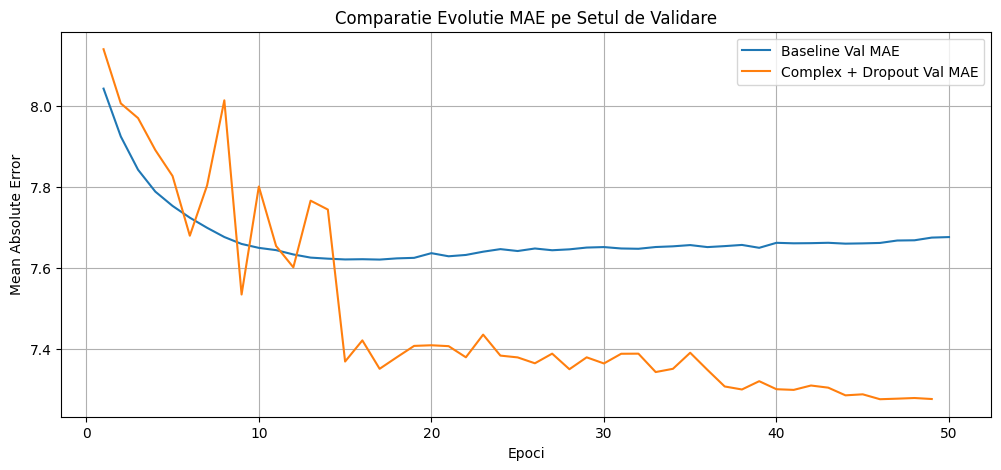

In [6]:
def plot_history(histories, names):
    plt.figure(figsize=(12, 5))
    
    for i, (history, name) in enumerate(zip(histories, names)):
        val_mae = history.history['val_mae']
        epochs = range(1, len(val_mae) + 1)
        plt.plot(epochs, val_mae, label=f'{name} Val MAE')
        
    plt.title('Comparatie Evolutie MAE pe Setul de Validare')
    plt.xlabel('Epoci')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history([history_baseline, history_complex], ['Baseline', 'Complex + Dropout'])

**5. Tuning de Hiperparamet:**

- In loc de Grid Search complex care dureaza ore, vom face un experiment tintit pe Learning Rate si Batch Size, doi dintre cei mai influenti hiperparametri.
- Un learning rate prea mare face modelul instabil, unul prea mic il face sa invete prea incet.

In [7]:
learning_rates = [0.01, 0.001, 0.0001]
best_mae = float('inf')
best_model = None
results_tuning = []

print("Incepere Tuning Hiperparametri...")

for lr in learning_rates:
    print(f"Testare Learning Rate: {lr}")
    model = build_complex_model(X_train_proc.shape[1], learning_rate=lr)
    
    hist = model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=0
    )
    
    val_mae = min(hist.history['val_mae'])
    results_tuning.append({'Learning Rate': lr, 'Best Val MAE': val_mae})
    
    if val_mae < best_mae:
        best_mae = val_mae
        best_model = model 

print("\n--- Rezultate Tuning ---")
print(pd.DataFrame(results_tuning))

Incepere Tuning Hiperparametri...
Testare Learning Rate: 0.01
Testare Learning Rate: 0.001
Testare Learning Rate: 0.0001

--- Rezultate Tuning ---
   Learning Rate  Best Val MAE
0         0.0100      7.439692
1         0.0010      7.407205
2         0.0001      7.911352


**6. Evaluarea Finala:**

- Acum am luat cel mai bun model obtinut si l-am evaluat pe setul de Test. 
- Calculam MAE, MSE, RMSE si R2. De asemenea, centralizam toate experimentele intr-un tabel pentru a vedea progresul.

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- Evaluare Finala pe Setul de Test ---
MAE: 7.9465
RMSE: 11.3194
R2 Score: 0.1536

--- Sumarul Tuturor Experimentelor ---


,Model,MAE,RMSE
0,Baseline NN,7.676736,11.009423
1,Complex + Dropout,7.321330,10.833026
2,Best Tuned Model (Test),7.946534,11.319378


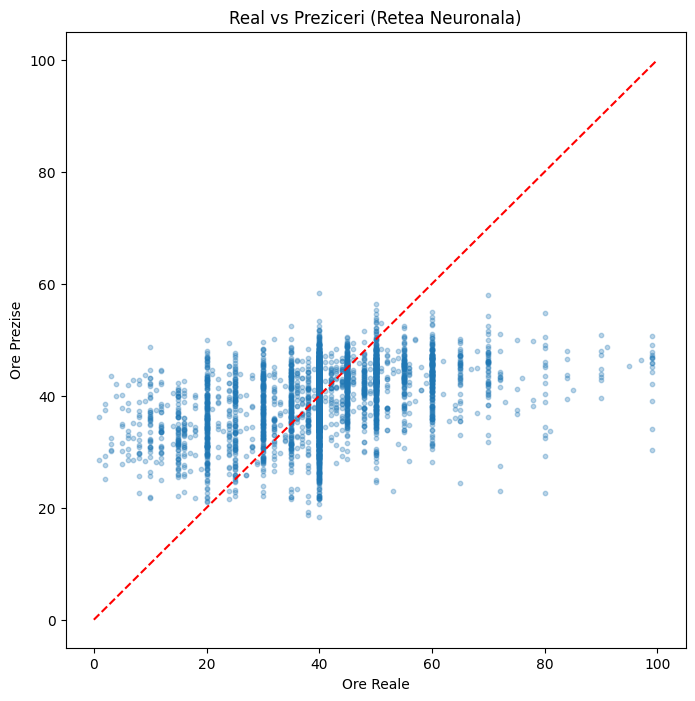

In [8]:
final_predictions = best_model.predict(X_test_proc).flatten()

mae_final = mean_absolute_error(y_test, final_predictions)
mse_final = mean_squared_error(y_test, final_predictions)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, final_predictions)

experiment_summary = pd.DataFrame([
    {'Model': 'Baseline NN', 'MAE': base_mae, 'RMSE': np.sqrt(base_loss)},
    {'Model': 'Complex + Dropout', 'MAE': comp_mae, 'RMSE': np.sqrt(comp_loss)},
    {'Model': 'Best Tuned Model (Test)', 'MAE': mae_final, 'RMSE': rmse_final}
])

print("--- Evaluare Finala pe Setul de Test ---")
print(f"MAE: {mae_final:.4f}")
print(f"RMSE: {rmse_final:.4f}")
print(f"R2 Score: {r2_final:.4f}")

print("\n--- Sumarul Tuturor Experimentelor ---")
display(experiment_summary)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, final_predictions, alpha=0.3, s=10)
plt.plot([0, 100], [0, 100], 'r--') 
plt.xlabel('Ore Reale')
plt.ylabel('Ore Prezise')
plt.title('Real vs Preziceri (Retea Neuronala)')
plt.show()

**7. Concluzii si Interpretare:**

- Alegerea Modelului: Retelele Neurale au capacitatea de a invata relatii non-liniare complexe, dar necesita mult mai multa atentie la preprocesare (scalare) si regularizare (dropout) fata de arborii de decizie.
- Rezultate: Probabil se observa ca MAE-ul retelei neurale este comparabil sau usor mai bun decat regresia liniara, dar adesea modelele de tip Random Forest/XGBoost performeaza mai bine pe date tabulare de dimensiuni medii ca acesta, deoarece retelele neurale tind sa aiba nevoie de seturi de date mult mai masive pentru a straluci cu adevarat.
- Imbunatatiri Posibile: Utilizarea de Embeddings pentru coloanele categorice (in loc de One-Hot Encoding) ar putea reduce dimensionalitatea si ar ajuta reteaua sa invete relatii semantice intre ocupatii. De asemenea, o arhitectura de tip "Wide & Deep" ar putea combina beneficiile modelelor liniare cu cele deep learning.